## Spectrograph HP8566

Let's imitate the style of the following spectrograph

![Image Description](HP8566_Screencap_1.jpg)
![Image Description](HP8566_Screencap_2.jpg)
![Image Description](HP8566_Screencap_3.jpg)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.interpolate import interp1d
import cv2
from PIL import Image, ImageFilter

C:\Users\guill\AppData\Local\Temp\ipykernel_4740\129825042.py:87: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(x_sampled, y_sampled, poly_degree)
C:\Users\guill\AppData\Local\Temp\ipykernel_4740\129825042.py:87: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(x_sampled, y_sampled, poly_degree)
C:\Users\guill\AppData\Local\Temp\ipykernel_4740\129825042.py:87: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(x_sampled, y_sampled, poly_degree)
C:\Users\guill\AppData\Local\Temp\ipykernel_4740\129825042.py:87: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(x_sampled, y_sampled, poly_degree)


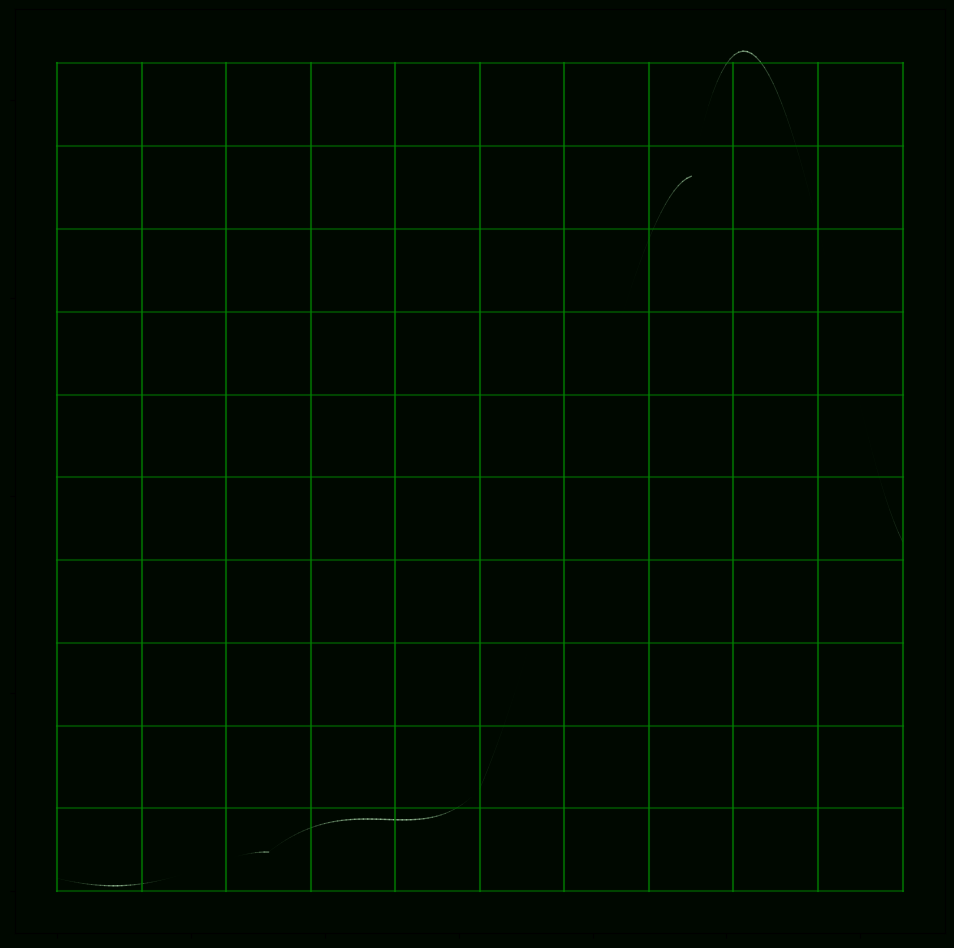

In [7]:
'''
This cell in essence approximates the images above, vector graphics where an electron beam is steered into a 
green phosphorous screen shining a dot into it, the faster this dot sweeps between data points the 
less intensity is transmitted into the phosphor and thus the dimmer the line gets. 

To replicate this we first generate some placeholder data, then we scan through the data N points at a time,
sampling our data into much smaller chuncks, these chunks can now be fitted to polynomials which is a way to
simulate how the beam will steer through the data points, the whole acquisition + beam steering chain has a 
bandwidth and thus drawing perfect lines between the points is impossible, an infinite bandwidth would be 
needed to change directions instantaneusly, thay's why we use a polinomial to change directions in a smooth
manner. 

We now have a way to simulate the beam path along our data points and now we need to calculate the speed, 
we compute the gradient for each point and compute a sort of normalized inverse function for it, this way
it is conditioned for the final step. We plot one line between each pair of interpolated points, this line
will have a brightness, width and opacity that is inversely proportional to it's speed (gradient).

We repeat these steps for every chunck in our dataset and we plot the whole graph. Lastly we do some aesthetic
changes to display some text, gridlines and background color that is reminiscent of the screen pictured above.

'''



######################################### Parameters #########################################
# Visual parameters
#
#  These parameters only affect visual elements in the graph
#
Num_vertical_lines = 10                 # Number of vertical lines for the grid line 
Num_horizontal_lines = 10               # Number of horizontal lines for the grid line
vector_lines_color = 'green'            # Color for grid line and text
RGB_brightest_trace = (0.8, 1, 0.8)     # Brightest green shade for the gradient in the graph color
RGB_darkest_trace = (0, 0.2, 0)         # Darkest green shade for the gradient in the graph color
backgroung_color = '#000800'            # Background screen color
grid_opacity = 0.7                      # Opacity for the grid lines and text
graph_opacity = 0.5                     # Opacity for the graphed line
grid_linewidth = 1                      # Grid lines width
graph_linewidth = 1                     # Graph lines width

# Performance parameters
# 
# These parameters control how accurate the "simulation" for the ray which is inversely proportional
# to computation time
# 
Num_sample_points = 4                   # Number of data points that will be sampled at each loop and fitted to a polynomial
poly_degree = Num_sample_points + 1     # This polynome will need to be one order higher than the number 
                                        # to fit through all of them
Interpolation_factor = 50               # Number of interpolated points between the sample points



# Set up the figure with a black background and white grid lines
fig, ax = plt.subplots(figsize=(12, 12), facecolor=backgroung_color)


############################################ Data ############################################

# Generate some example data

# Gaussian function: mean = 0, standard deviation = 1
x = np.linspace(0, 10, 20)
mu = 0  # Mean
sigma = 1  # Standard deviation
gaussian = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - 5 - mu)**2 / (2 * sigma**2))

# Add some random noise to the Gaussian
noise = np.random.normal(0, 0.02, x.shape)  # Noise with mean 0 and small standard deviation
y = noise + gaussian

# Create a colormap with a more pronounced gradient (dark green to bright green) the color for each segment in the
# graph will be taken from here
green_cmap = LinearSegmentedColormap.from_list('custom_gradient', [RGB_darkest_trace, RGB_brightest_trace])  # Dark green to light green

# Walk though data splitting into chuncks of length Num_sample_points
max_x = 0
min_x = 0
max_y = 0
min_y = 0
for index in range(0, int((len(x)-Num_sample_points) / Num_sample_points)):

    # Get a sample of Num points to interpolate 
    x_sampled = x[(Num_sample_points-1)*index : (Num_sample_points-1)*index+Num_sample_points]
    y_sampled = y[(Num_sample_points-1)*index : (Num_sample_points-1)*index+Num_sample_points]

    # Fit a polynomial of the specified degree to the sampled points
    poly_coeffs = np.polyfit(x_sampled, y_sampled, poly_degree)

    # Generate new x-values for interpolation between the sampled points
    min_x_sampled = x_sampled[0]
    max_x_sampled = x_sampled[-1]
    min_y_sampled = y_sampled.min()
    max_y_sampled = y_sampled.max()
    x_interpolated = np.linspace(min_x_sampled, max_x_sampled, Interpolation_factor)

    # Evaluate the polynomial at the interpolated x-values
    y_interpolated = np.polyval(poly_coeffs, x_interpolated)

    # Electron beam speed is the gradient (used to determine brightness/green intensity)
    dydx = abs(np.gradient(y_interpolated, x_interpolated))

    # Normalize the derivative values for color mapping
    norm = Normalize(vmin=np.min(dydx), vmax=np.max(dydx))
    z = 1 - norm(dydx)  # Invert so that higher speeds generate darker greens

    # Plot each interpolated segment with varying color based on speed
    for index in range(0, len(x_interpolated)-1):
        ax.plot([x_interpolated[index], x_interpolated[index+1]], 
                [y_interpolated[index], y_interpolated[index+1]], 
                color=green_cmap(z[index]),
                linewidth=graph_linewidth*z[index], 
                alpha=graph_opacity*z[index])
    
    
    # Keep count of where to place limits later on graph, we will use this to fit the 
    # grid lines
    if (max_x_sampled > max_x):
        max_x = max_x_sampled

    if (min_x_sampled < min_x):
        min_x = min_x_sampled

    if (max_y_sampled > max_y):
        max_y = max_y_sampled

    if (min_y_sampled < min_y):
        min_y = min_y_sampled

    




############################################ Grid ############################################

# Make a fake hacky grid line because I can't get ax.grid to do what I want.
x_ticks_spacing = ( max_x - min_x ) / Num_vertical_lines

for index in range(0, Num_vertical_lines+1):
    # Create a vertical line defined by 2 points at the intended horizontal position that goes from minimum graph to max graph height
    x_points = [min_x + index * x_ticks_spacing, min_x + index * x_ticks_spacing]
    y_points = [min_y, max_y]
    ax.plot(x_points, y_points, linestyle='-', color=vector_lines_color, alpha=grid_opacity)

y_ticks_spacing = ( max_y - min_y ) / Num_horizontal_lines
for index in range(0, Num_horizontal_lines+1):
    # Create a vertical line defined by 2 points at the intended horizontal position that goes from minimum graph to max graph height
    x_points = [min_x, max_x]
    y_points = [min_y + index * y_ticks_spacing, min_y + index * y_ticks_spacing]
    ax.plot(x_points, y_points, linestyle='-', color=vector_lines_color, alpha=graph_opacity)


# Customize the plot to simulate an oscilloscope look
ax.set_facecolor(backgroung_color)  # Black background

# Remove axis ticks and labels for a cleaner look
ax.set_xticklabels([])
ax.set_yticklabels([])




############################################ Text ############################################

# Graphed text parameters
font = 'monospace'
plt.rcParams['font.size'] = 8  # Set default font size for all text
plt.rcParams['font.weight'] = 'bold'  # Set default font weight (normal, bold, etc.)
plt.rcParams['font.style'] = 'normal'  # Set default font style (normal, italic, oblique)
#plt.rcParams['text.color'] = ''  # Set default font color
plt.rcParams['text.usetex'] = False  # Disable LaTeX processing
plt.rcParams['font.family'] = font  # Set to desired font

# Add text to simulate an oscilloscope display (adjust positions as needed)
top_height = max_y*1.01
lower_height = min_y*1.3
line_height = 0.1

# Draw some text that is reminiscent of the HP8566 interface
'''
plt.text(0, top_height, "0.0dBm", color=vector_lines_color, alpha=graph_opacity)
plt.text(-0.6, top_height, "REF", color=vector_lines_color, alpha=graph_opacity)
plt.text(1.2, top_height, "ATTEN 10 dB", color=vector_lines_color, alpha=graph_opacity)

plt.text(-0.6, lower_height, "START", color=vector_lines_color, alpha=graph_opacity)
plt.text(0.2, lower_height, "0 Hz", color=vector_lines_color, alpha=graph_opacity)
plt.text(8.0, lower_height, "RBW 1 MHz", color=vector_lines_color, alpha=graph_opacity)
'''
plt.savefig('original.png')
# Display the plot
plt.show()


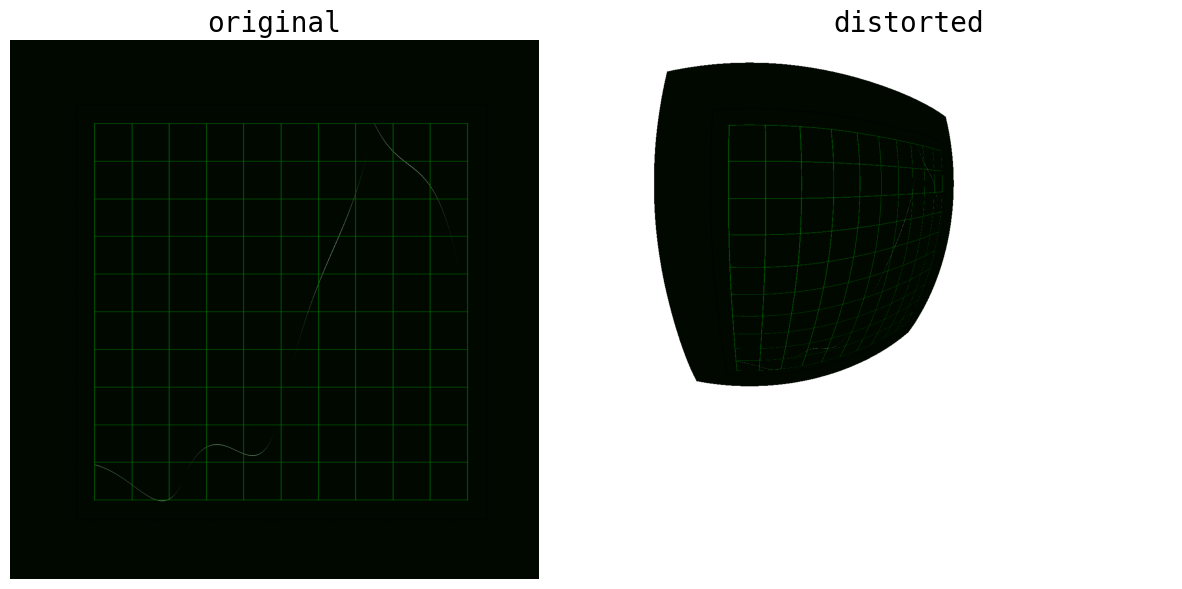

In [4]:
K = np.array( [[338.37324094,0,319.5],[0,339.059099,239.5],[0,0,1]], dtype=np.float32)   # camera intrinsic parameters
d = np.array([0.17149, -0.27191, 0.25787, -0.08054], dtype=np.float32) # k1, k2, k3, k4 - distortion coefficients

def apply_fisheye_effect(img, K, d):

   indices = np.array(np.meshgrid(range(img.shape[0]), range(img.shape[1]))).T \
            .reshape(np.prod(img.shape[:2]), -1).astype(np.float32)

   Kinv = np.linalg.inv(K)
   indices1 = np.zeros_like(indices, dtype=np.float32)
   for i in range(len(indices)):
      x, y = indices[i]
      indices1[i] = (Kinv @ np.array([[x], [y], [1]])).squeeze()[:2]
   indices1 = indices1[np.newaxis, :, :]

   in_indices = cv2.fisheye.distortPoints(indices1, K, d)
   indices, in_indices = indices.squeeze(), in_indices.squeeze()

   distorted_img = np.zeros_like(img)
   for i in range(len(indices)):
      x, y = indices[i]
      ix, iy = in_indices[i]
      if (ix < img.shape[0]) and (iy < img.shape[1]):
         distorted_img[int(ix),int(iy)] = img[int(x),int(y)]

   return distorted_img

K = np.array( [[338.37324094,0,319.5],[0,339.059099,239.5],[0,0,1]],dtype=np.float32) # camera intrinsic params
d = np.array([0.17149, -0.27191, 0.25787, -0.08054],dtype=np.float32) # k1, k2, k3, k4 - distortion coefficients

img = plt.imread('original.png')
img = img / img.max()
distorted_img = apply_fisheye_effect(img, K, d)

plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(img, aspect='auto'), plt.axis('off'), plt.title('original', size=20)
plt.subplot(122), plt.imshow(distorted_img, aspect='auto'), plt.axis('off'), plt.title('distorted', size=20)
plt.show()

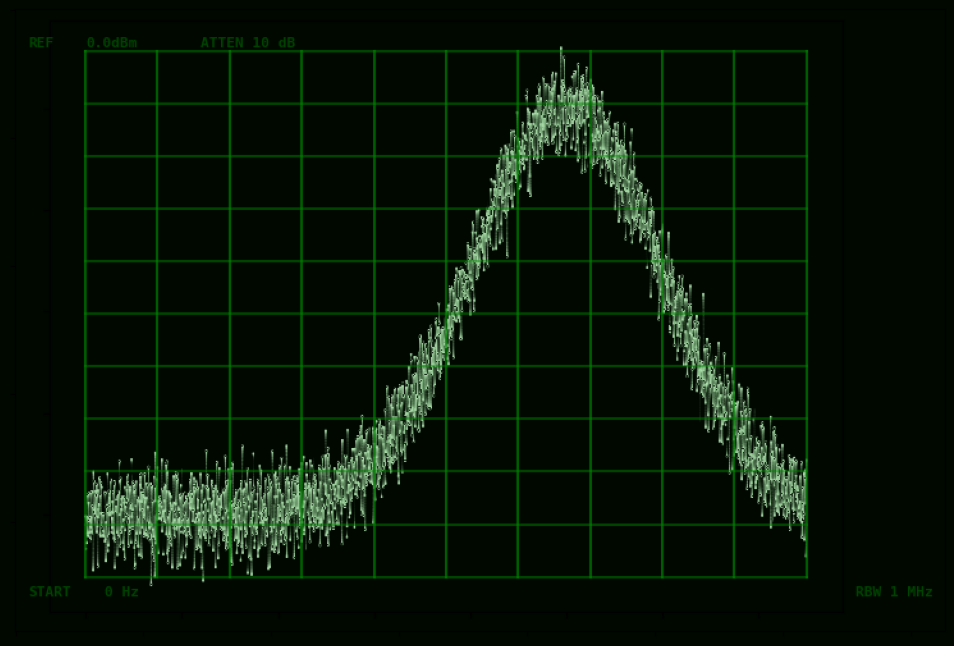

In [5]:
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image using Pillow
image = Image.open('Final_flat.png')

# Check if the image has an alpha channel (RGBA)
if image.mode == 'RGBA':
    # Convert the original image to RGB to remove alpha channel
    image = image.convert("RGB")

# Convert the image to an array for processing
image_array = np.array(image)

# Get image dimensions (height, width, channels)
h, w = image_array.shape[:2]

# Step 2: Apply a filter to isolate the bright areas of the image
# Convert the image to grayscale to create a brightness mask
gray_image = image.convert('L')  # Convert to grayscale

# Threshold the grayscale image to isolate bright areas (adjust threshold as needed)
threshold_value = 200  # Adjust this value (0 to 255) to set the brightness threshold
bright_areas = np.array(gray_image) > threshold_value

# Step 3: Apply Gaussian blur to the image to simulate bloom
bloom_image = image.filter(ImageFilter.GaussianBlur(radius=40))  # Adjust radius for bloom effect

# Convert the bloom image to RGB to ensure it matches the original image's format
bloom_image = bloom_image.convert("RGB")

# Step 4: Blend the blurred bloom image with the original image
bloomed_array = np.where(np.repeat(bright_areas[:, :, np.newaxis], 3, axis=2), np.array(bloom_image), image_array)

# Convert back to Image format
bloomed_image = Image.fromarray(bloomed_array.astype('uint8'))

# Step 5: Display the bloomed image
fig, ax = plt.subplots(figsize=(12, 12), facecolor=backgroung_color)
plt.imshow(bloomed_image)
# Remove axis ticks and labels for a cleaner look
ax.set_xticklabels([])
ax.set_yticklabels([])
#plt.savefig('blurr_comparison.png')
plt.show()
